Introduction
------------

This notebook introduces a way to use partial Principal Component Analysis to address the collinearity issue in the data. I first classify the variables into small groups which similar features, for example, church_count, build_count, cafe_price and etc. Then apply a PCA for each group of variables and use a stop criteria of 0.95 of total variance to pick the number of principal component. Finally, I assemble the data and draw the correlation plots to compare before and after transformation of the original data.


In [1]:
## Load packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from ggplot import *

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [2]:
## Load data into Python

train = pd.read_csv('../input/train.csv', parse_dates=['timestamp'])
test = pd.read_csv('../input/test.csv', parse_dates=['timestamp'])
macro = pd.read_csv('../input/macro.csv', parse_dates=['timestamp'])

In [3]:
print(train.columns)
print(train.shape)
print(test.shape)

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=292)
(30471, 292)
(7662, 291)


In [4]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64


TypeError: slice indices must be integers or None or have an __index__ method

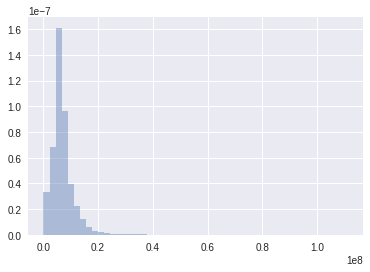

In [5]:
## Describe the output field
print(train['price_doc'].describe())
sns.distplot(train['price_doc'])

The dependent variable is skewed (as expected for dollars). The easiest would be to take a log tranformation

count    30471.000000
mean        15.609483
std          0.604574
min         11.512935
25%         15.371548
50%         15.651990
75%         15.931766
max         18.526041
Name: LogAmt, dtype: float64


TypeError: slice indices must be integers or None or have an __index__ method

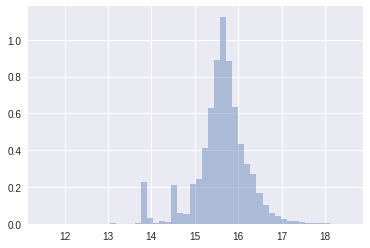

In [6]:
train['LogAmt']=np.log(train.price_doc+1.0)
print(train['LogAmt'].describe())
sns.distplot(train['LogAmt'])

** Note the two small bars between 13 and 14, and 14 and 15. We will need to dig into that and see that happens there **.

In [7]:
## Merge data into one dataset to prepare compare between train and test
train_1 = train.copy()
train_1['Source']='Train'
test_1 = test.copy()
test_1['Source']='Test'
alldata = pd.concat([train_1, test_1],ignore_index=True)

macro.columns = ['mac__'+c if c!='timestamp' else 'timestamp' for c in macro.columns ]
alldata=alldata.merge(macro,on='timestamp',how='left')
print(alldata.shape)

(38133, 393)


Most fields are numeric, and a few of them are object.

In [8]:
## Numerical and Categorical data types
alldata_dtype=alldata.dtypes
display_nvar = len(alldata.columns)
alldata_dtype_dict = alldata_dtype.to_dict()
alldata.dtypes.value_counts()

float64           216
int64             157
object             19
datetime64[ns]      1
dtype: int64

Step 2: Transform Variables and Missing Data
---------------------------

**Variable Description**

I wrote this function with intension to compare train/test data and check if some variable is illy behaved. It is modified a little to fit this dataset to compared between normal/fraud subset.

It can be applied to both numeric and object data types:

  1. When the data type is object, it will output the value count of each categories
  2. When the data type is numeric, it will output the quantiles
  3. It also seeks any missing values in the dataset

In [9]:
def var_desc(dt,alldata):
    print('--------------------------------------------')
    for c in alldata.columns:
        if alldata[c].dtype==dt:
            t1 = alldata[alldata.Source=='Train'][c]
            t2 = alldata[alldata.Source=='Test'][c]
            if dt=="object":
                f1 = t1[pd.isnull(t1)==False].value_counts()
                f2 = t2[pd.isnull(t2)==False].value_counts()
            else:
                f1 = t1[pd.isnull(t1)==False].describe()
                f2 = t2[pd.isnull(t2)==False].describe()
            m1 = t1.isnull().value_counts()
            m2 = t2.isnull().value_counts()
            f = pd.concat([f1, f2], axis=1)
            m = pd.concat([m1, m2], axis=1)
            f.columns=['Train','Test']
            m.columns=['Train','Test']
            print(dt+' - '+c)
            print('UniqValue - ',len(t1.value_counts()),len(t2.value_counts()))
            print(f.sort_values(by='Train',ascending=False))
            print()

            m_print=m[m.index==True]
            if len(m_print)>0:
                print('missing - '+c)
                print(m_print)
            else:
                print('NO Missing values - '+c)
            if dt!="object":
                if len(t1.value_counts())<=10:
                    c1 = t1.value_counts()
                    c2 = t2.value_counts()
                    c = pd.concat([c1, c2], axis=1)
                    f.columns=['Train','Test']
                    print(c)
            print('--------------------------------------------')

In [10]:
## Uncomment to run variable description
## var_desc('object',alldata)

There are only a few variables that are object type and most of them are "yes" and "no". It is reasonable to convert them into 0 and 1 numerical variables. 

In [11]:
## convert obj to num
for c in alldata.columns:
    if alldata[c].dtype=='object' and c not in ['sub_area','timestamp','Source']:
        if len(alldata[c].value_counts())==2:
            alldata['num_'+c]=[0 if x in ['no','OwnerOccupier'] else 1 for x in alldata[c]]
        if len(alldata[c].value_counts())==5:
            alldata['num_'+c]=0
            alldata['num_'+c].loc[alldata[c]=='poor']=0
            alldata['num_'+c].loc[alldata[c]=='satisfactory']=1
            alldata['num_'+c].loc[alldata[c]=='good']=2
            alldata['num_'+c].loc[alldata[c]=='excellent']=3
            alldata['num_'+c].loc[alldata[c]=='no data']=1

In [12]:
## missing values
missing_col = [[c,sum(alldata[alldata.Source=='Train'][c].isnull()==True),sum(alldata[alldata.Source=='Test'][c].isnull()==True)] for c in alldata.columns]
missing_col = pd.DataFrame(missing_col,columns=['Var','missingTrain','missingTest'])

** Missing Values **

Below is an analysis of missing values. There are a couple variables with very rate of missing. So we want to keep them in the resv_col list so that we don't PCA them and make the entire set of the principal components as missing. 

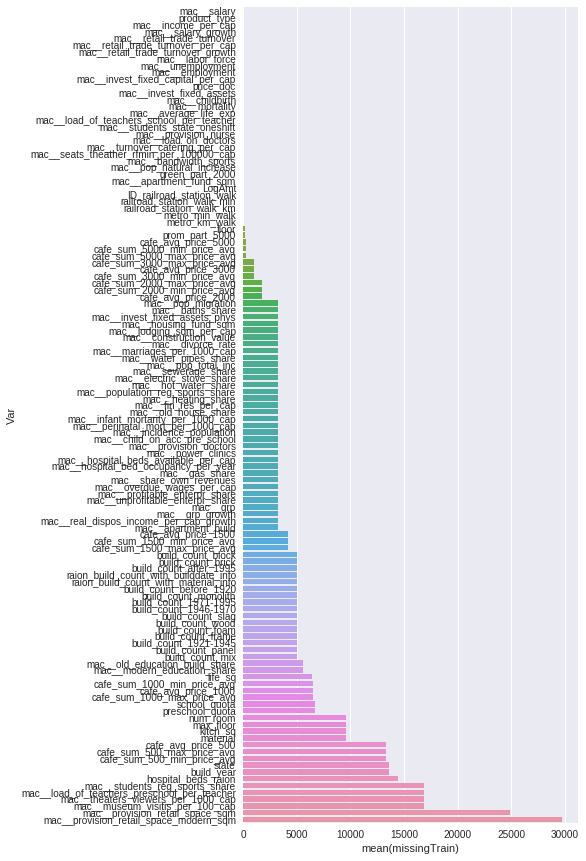

In [13]:
missingdf=missing_col[missing_col.missingTrain+missing_col.missingTest>0]
missingdf=missingdf.sort('missingTrain')
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(y=missingdf.Var,x=missingdf.missingTrain)

## Step 3: Principal Component Analysis##

First, we group variables into small categories, 

Then apply PCA on each of the categories and show correlation plots

In [14]:
excl_col=['id','timestamp','sub_area'] + [c for c in alldata.columns if alldata[c].dtype=='object']
resv_col=['price_doc','LogAmt','Source','cafe_sum_500_max_price_avg','cafe_sum_500_min_price_avg','cafe_avg_price_500','hospital_beds_raion']
def sel_grp(keys):
    lst_all = list()
    for k in keys:
        lst = [c for c in alldata.columns if c.find(k)!=-1 and c not in excl_col and c not in resv_col]
        lst = list(set(lst))
        lst_all += lst
    return(lst_all)

In [15]:
col_grp = dict({})
col_grp['people']=sel_grp(['_all','male'])
col_grp['id'] = sel_grp(['ID_'])
col_grp['church']=sel_grp(['church'])
col_grp['build']=sel_grp(['build_count_'])
col_grp['cafe']=sel_grp(['cafe_count'])
col_grp['cafeprice']=sel_grp(['cafe_sum','cafe_avg'])
col_grp['km']=sel_grp(['_km','metro_min','_avto_min','_walk_min','_min_walk'])
col_grp['mosque']=sel_grp(['mosque_count'])
col_grp['market']=sel_grp(['market_count'])
col_grp['office']=sel_grp(['office_count'])
col_grp['leisure']=sel_grp(['leisure_count'])
col_grp['sport']=sel_grp(['sport_count'])
col_grp['green']=sel_grp(['green_part'])
col_grp['prom']=sel_grp(['prom_part'])
col_grp['trc']=sel_grp(['trc_count'])
col_grp['sqm']=sel_grp(['_sqm_'])
col_grp['raion']=sel_grp(['_raion'])
col_grp['macro']=sel_grp(['mac__'])
col_grp.keys()

dict_keys(['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro'])

In [16]:
col_tmp = list()
for d in col_grp:
    col_tmp+=(col_grp[d])
col_grp['other']=[c for c in alldata.columns if c not in col_tmp and c not in excl_col and c not in resv_col]
col_grp['other']  ## these 'other' variables are not to be PCA

['area_m',
 'build_year',
 'children_preschool',
 'children_school',
 'floor',
 'full_sq',
 'green_zone_part',
 'indust_part',
 'kitch_sq',
 'life_sq',
 'material',
 'max_floor',
 'num_room',
 'preschool_quota',
 'raion_popul',
 'school_quota',
 'state',
 'num_big_road1_1line',
 'num_culture_objects_top_25',
 'num_ecology',
 'num_product_type',
 'num_railroad_1line',
 'num_water_1line']

In [17]:
## remove variables in macro data with too many missing data
macro_missing_2 = pd.DataFrame([[c,sum(alldata[c].isnull())] for c in col_grp['macro']],columns=['Var','Missing'])
macro_missing_3=macro_missing_2[macro_missing_2.Missing>5000]
print(macro_missing_3)
excl_col+=list(macro_missing_3.Var)
print(excl_col)

col_grp['macro']=sel_grp(['mac__'])

                                            Var  Missing
1                 mac__invest_fixed_assets_phys    10901
2   mac__load_of_teachers_preschool_per_teacher    24563
4                       mac__construction_value    10901
5                       mac__share_own_revenues    10901
6              mac__perinatal_mort_per_1000_cap    10901
7                            mac__pop_total_inc    10901
8                     mac__incidence_population    10901
9                            mac__heating_share    10901
12                               mac__gas_share    10901
17                         mac__apartment_build    10901
18                         mac__old_house_share    10901
19         mac__hospital_beds_available_per_cap    10901
20                           mac__pop_migration    10901
21                        mac__housing_fund_sqm    10901
22           mac__theaters_viewers_per_1000_cap    24563
26           mac__infant_mortarity_per_1000_cap    10901
29                mac__profitab

In [18]:
loopkeys=list(col_grp.keys())
print(loopkeys)

['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro', 'other']


In [19]:
def partial_pca(var,data,col_grp):
    from sklearn.decomposition import PCA
    import bisect
    pca = PCA()
    df = data[col_grp[var]].dropna()
    print([len(data[col_grp[var]]), len(df)])
    df = (df-df.mean())/df.std(ddof=0)
    pca.fit(df)
    varexp = pca.explained_variance_ratio_.cumsum()
    cutoff = bisect.bisect(varexp, 0.95)
    #print(cutoff)
    #print(pca.explained_variance_ratio_.cumsum())
    newcol=pd.DataFrame(pca.fit_transform(X=df)[:,0:(cutoff+1)],columns=['PCA_'+var+'_'+str(i) for i in range(cutoff+1)],index=df.index)
    #print(newcol)
    col_grp['PCA_'+var]=list(newcol.columns)
    return(newcol,col_grp,pca)

In [20]:
for c in loopkeys:
    if c!='other':
        print(c)
        newcol,col_grp,pca = partial_pca(c,alldata,col_grp)
        alldata=alldata.join(newcol)
        print(alldata.shape)

people
[38133, 38133]
(38133, 409)
id
[38133, 38074]
(38133, 415)
church
[38133, 38133]
(38133, 419)
build
[38133, 31924]
(38133, 426)
cafe
[38133, 38133]
(38133, 429)
cafeprice
[38133, 30387]
(38133, 433)
km
[38133, 38074]
(38133, 451)
mosque
[38133, 38133]
(38133, 456)
market
[38133, 38133]
(38133, 460)
office
[38133, 38133]
(38133, 462)
leisure
[38133, 38133]
(38133, 465)
sport
[38133, 38133]
(38133, 468)
green
[38133, 38114]
(38133, 471)
prom
[38133, 37863]
(38133, 474)
trc
[38133, 38133]
(38133, 477)
sqm
[38133, 27232]
(38133, 484)
raion
[38133, 38133]
(38133, 497)
macro
[38133, 34150]
(38133, 509)


Correlation
------
Correlation is useful to find peers of input field so we are aware when building models, either to transform them (principal component) or remove one of the two.
The first plot below the overall correlation matrix and there are blocks of variables that are highly correlated
The second plot shows the highly correlated variables with response.

In [21]:
wpca=list()
wopca=list()
for c in col_grp.keys():
    if c.find('PCA_')!=-1:
        wpca+=col_grp[c]
    else:
        wopca+=col_grp[c]
        
wpca+=col_grp['other']
wpca+=resv_col
wopca+=col_grp['other']
wopca+=resv_col

wpca=list(set(wpca))
wopca=list(set(wopca))

wpca.sort()
wopca.sort()

Below is a comparison of w/o PCA and w/ PCA correlation, after PCA transformation, it looks much better in terms of high correlated variables. It is also interesting to notice that some of the intra-group principal components have high correlations. 

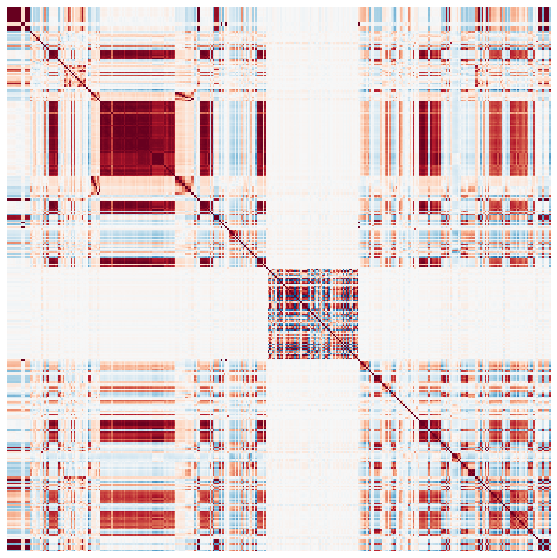

In [22]:
## Correlation without PCA
corrmat = alldata[wopca].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True,xticklabels=False,yticklabels=False,cbar=False,annot=False);

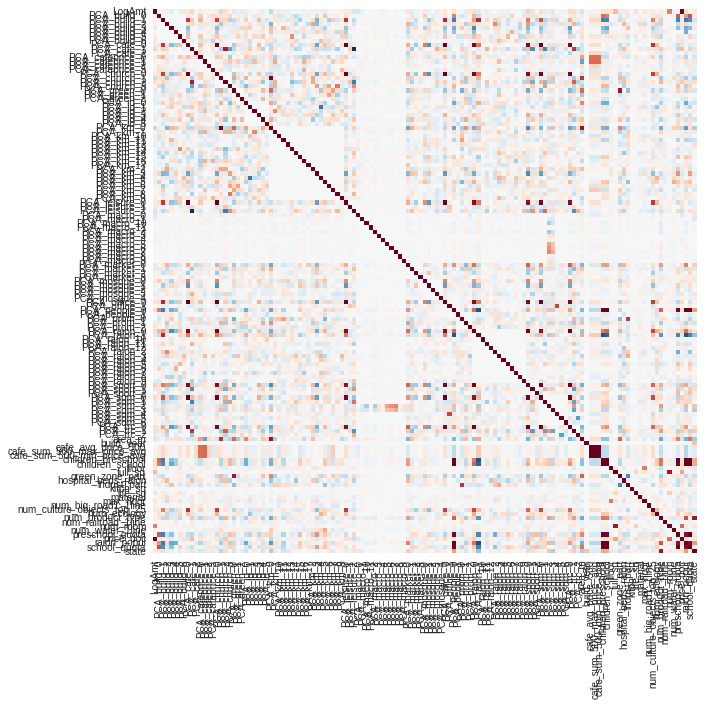

In [23]:
## Correlation with PCA
corrmat = alldata[wpca].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True,xticklabels=True,yticklabels=True,cbar=False,annot=False);

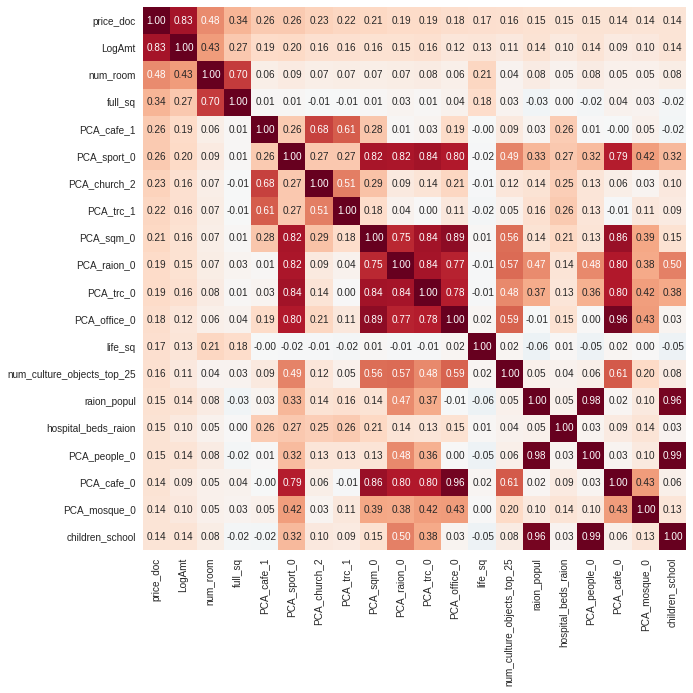

In [24]:
## Top 20 correlated variables
corrmat = alldata[wpca].corr()
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price_doc')['price_doc'].index
cm = alldata[cols].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

XGB on the PCA transformed Data
---------

Now PCA transformed data shows much better correlation. Next we will test a simple XGB model and see its performance. 

In [25]:
## these are the variables going into the model.
alldata[wpca].columns

Index(['LogAmt', 'PCA_build_0', 'PCA_build_1', 'PCA_build_2', 'PCA_build_3',
       'PCA_build_4', 'PCA_build_5', 'PCA_build_6', 'PCA_cafe_0', 'PCA_cafe_1',
       ...
       'num_ecology', 'num_product_type', 'num_railroad_1line', 'num_room',
       'num_water_1line', 'preschool_quota', 'price_doc', 'raion_popul',
       'school_quota', 'state'],
      dtype='object', length=132)

In [26]:
## Add a few more features suggested by other discussions
##
# Add month-year
month_year = (alldata.timestamp.dt.month + alldata.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
alldata['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (alldata.timestamp.dt.weekofyear + alldata.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
alldata['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
alldata['month'] = alldata.timestamp.dt.month
alldata['dow'] = alldata.timestamp.dt.dayofweek

# Other feature engineering
alldata['rel_floor'] = alldata['floor'] / alldata['max_floor'].astype(float)
alldata['rel_kitch_sq'] = alldata['kitch_sq'] / alldata['full_sq'].astype(float)

In [27]:
wpca +=['month_year_cnt','week_year_cnt','dow','month','rel_floor','rel_kitch_sq']
wopca+=['month_year_cnt','week_year_cnt','dow','month','rel_floor','rel_kitch_sq']
allfeature=list(set(wpca+wopca))

In [28]:
## let's try a 5-fold CV
from sklearn.model_selection import KFold
kf = KFold(5,shuffle =True)

In [29]:
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 12,
    'subsample': 1,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'min_child_weight': 200
}

def cv_xgb(val_train_X,val_train_Y,val_val_X,val_val_Y):
    dtrain = xgb.DMatrix(val_train_X, val_train_Y, feature_names=val_train_X.columns)
    dval = xgb.DMatrix(val_val_X, val_val_Y, feature_names=val_val_X.columns)

    # Uncomment to tune XGB `num_boost_rounds`
    partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                           early_stopping_rounds=50, verbose_eval=20)

    num_boost_round = partial_model.best_iteration
    return(num_boost_round,partial_model.best_score)

In [30]:
train_col = [c for c in alldata[wpca].columns if c not in ['price_doc','Source']]
alldata_1 = alldata[alldata.Source=='Train'][train_col]

for val_train, val_val in kf.split(alldata_1):
    val_train_X = alldata_1.ix[val_train].drop('LogAmt',axis=1)
    val_train_Y = alldata_1.ix[val_train].LogAmt
    val_val_X = alldata_1.ix[val_val].drop('LogAmt',axis=1)
    val_val_Y = alldata_1.ix[val_val].LogAmt
    print("%s %s %s %s" % (val_train_X.shape, val_train_Y.shape, val_train.shape, val_val.shape))
    print(cv_xgb(val_train_X,val_train_Y,val_val_X,val_val_Y))
    break  ## this takes long to run, I am breaking it to demostrate; comment the line if you want full CV

(24376, 135) (24376,) (24376,) (6095,)
[0]	val-rmse:14.3686
Will train until val-rmse hasn't improved in 50 rounds.
[20]	val-rmse:5.17426
[40]	val-rmse:1.91031
[60]	val-rmse:0.81468
[80]	val-rmse:0.524164
[100]	val-rmse:0.4721
[120]	val-rmse:0.464403
[140]	val-rmse:0.463079
[160]	val-rmse:0.462677
[180]	val-rmse:0.462827
[200]	val-rmse:0.462693
Stopping. Best iteration:
[157]	val-rmse:0.462525

(157, 0.462525)


In [31]:
## Run it on the full model 
num_boost_round = 200
all_train_X = alldata_1.drop('LogAmt',axis=1)
all_train_Y = alldata_1.LogAmt
all_test_X = alldata[alldata.Source=='Test'][train_col].drop('LogAmt',axis=1)
dtrain_all = xgb.DMatrix(all_train_X, all_train_Y, feature_names=all_train_X.columns)
dtest      = xgb.DMatrix(all_test_X, feature_names=all_test_X.columns)
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

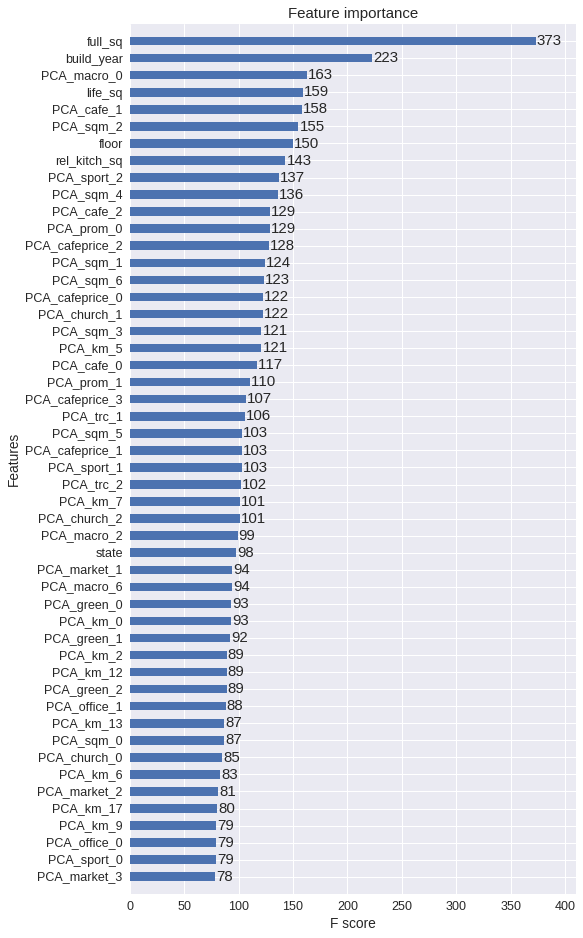

In [32]:
## important features
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [33]:
## Make a predicition
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1
id_test = alldata[alldata.Source=='Test'].id
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
df_sub.to_csv('sub_pca.csv', index=False)